## Pythonによる画像解析実例 #4: In vitroにおける蛍光タンパク質凝集体の定量的解析  
PPATプロジェクトにおける解析事例。  
精製Ade4-mNGのin vitro凝集体の形態と蛍光強度を測定。  
これまではFIJIを使用してJythonマクロで解析していたが、同等の機能をPythonで再現する。  
解析手順はIAP_ex2と同様、inputをnd2ファイルにする。

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import glob
import nd2
import os
import imageio
from tifffile import tifffile as tiff
import PySimpleGUI as sg

import matplotlib.pyplot as plt
from scipy import ndimage

import cv2
# from cv2_rolling_ball import subtract_background_rolling_ball

from skimage.color import label2rgb
from skimage.color import rgb2gray
from skimage import exposure
from skimage.filters import threshold_li
from skimage.measure import regionprops_table
from skimage.measure import label
from skimage.morphology import binary_opening
from skimage.morphology import binary_dilation
from skimage.morphology import extrema
from skimage.morphology import remove_small_objects
from skimage.morphology import square
from skimage.morphology import skeletonize
from skimage import restoration
from skimage.segmentation import clear_border
from skimage.util import img_as_ubyte
from skimage.util import invert
# from skimage.util import io

In [ ]:
nd2ファイルの読み込み  
ch1が緑蛍光、ch2が100倍位相差像、16bit画像

In [8]:
# folderS = "/Users/masak_takaine/230329_Ade4-mNG_ivc/nd_test"
# folderS = "/Users/masak_takaine/230329_Ade4-mNG_ivc/nd"
# folderS = "/Users/masak_takaine/221202_ivc_AMP/nd_test"
folderS = "/Users/masak_takaine/230331_Ade4-mNG_ivc/nd_test"
# path = "/Users/masak_takaine/230329_Ade4-mNG_ivc/nd_test/Ade4-mNG_500u_mock_034.nd2"
path = "/Users/masak_takaine/221202_ivc_AMP/nd_test/Ade4-mNG_amp_0uM_002.nd2"

In [33]:
nd2_arr =nd2.imread(path) # 画像をndarrayとして読み込み
with nd2.ND2File(path) as f: # with構文でファイルを開くと様々なメタデータが抽出できる
    vsize = f.voxel_size() # 
img = nd2_arr[0,:,:]
mask = img.copy()
phase = nd2_arr[1,:,:]
print("要素のデータ型:", img.dtype)

要素のデータ型: uint16


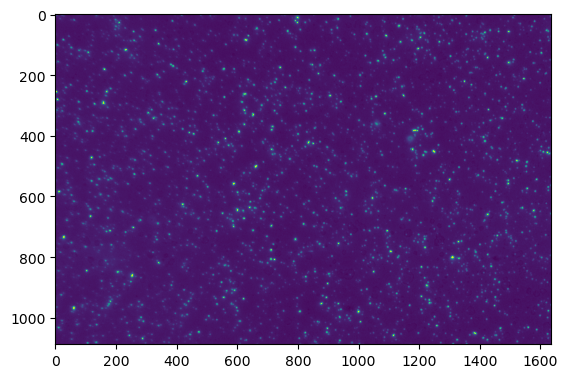

In [19]:
plt.imshow(img)

In [41]:
# x, y resolutions
reso = (1/vsize.x, 1/vsize.y)
print("X, Y resolutions (pixels per µm):", reso)

X, Y resolutions (pixels per µm): (11.361111111111303, 11.361111111111303)


### ドットの分節化  
maskの方でドットを分節化する、まず基本統計量を計算。

平均値: 3680.962238646987
最大値: 16267
最小値: 2711
分散: 658870.1279797774
標準偏差: 811.7081544371582


(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 5.568200e+04,
        1.576269e+06, 9.163800e+04, 2.334500e+04, 1.093200e+04,
        6.151000e+03, 3.879000e+03, 2.667000e+03, 1.968000e+03,
        1.451000e+03, 1.161000e+03, 9.080000e+02, 7.020000e+02,
        5.580000e+02, 5.130000e+02, 4.410000e+02, 1.703000e+03]),
 array([    0.  ,   813.35,  1626.7 ,  2440.05,  3253.4 ,  4066.75,
         4880.1 ,  5693.45,  6506.8 ,  7320.15,  8133.5 ,  8946.85,
         9760.2 , 10573.55, 11386.9 , 12200.25, 13013.6 , 13826.95,
        14640.3 , 15453.65, 16267.  ]),
 <BarContainer object of 20 artists>)

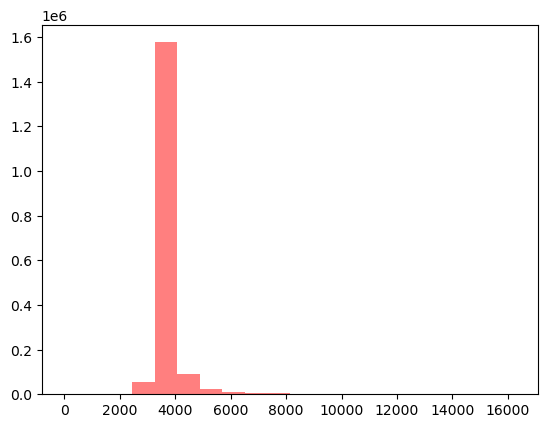

In [17]:
print("平均値:", img.mean())
print("最大値:", img.max())
print("最小値:", img.min())
print("分散:", img.var())
print("標準偏差:", img.std())
plt.hist(img.ravel(), bins = 20, range = [0, img.max()], color=(1,0,0), alpha = 0.5) # ravel()で1次元配列に戻す

バックグラウンドの除去  
処理速度が速い、`skimage.restoration.rolling_ball()`を使用する

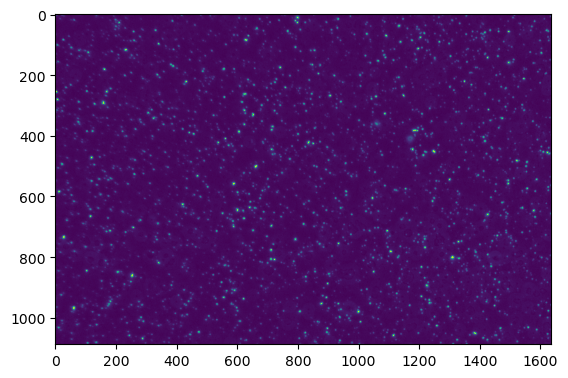

In [21]:
radius = 20
background = restoration.rolling_ball(mask, radius = radius, kernel=None,
                                     nansafe=False, num_threads=None)
filtered = mask - background
plt.imshow(filtered)

In [22]:
# 改めて基本統計量を測定
print("平均値:", filtered.mean())
print("最大値:", filtered.max())
print("最小値:", filtered.min())
print("分散:", filtered.var())
print("標準偏差:", filtered.std())

平均値: 496.5950095732058
最大値: 13290
最小値: 0
分散: 628157.8611978143
標準偏差: 792.5641054184919


In [23]:
# この時点での平均値+3xSDを閾値とする
thr = filtered.mean() + 3*filtered.std() # 2値化の閾値を設定

2値画像の作成、cv2.threshold()は16bit画像には使用できないので、numpy.where()を使用、処理後に8bitに変換

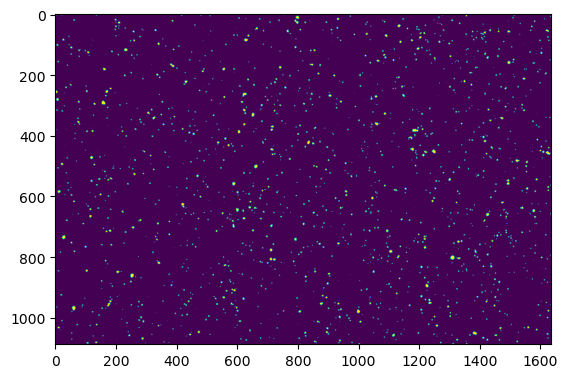

In [32]:
mask_bin = np.where(filtered > thr, 255, 0).astype("uint8")
plt.imshow(mask_bin)

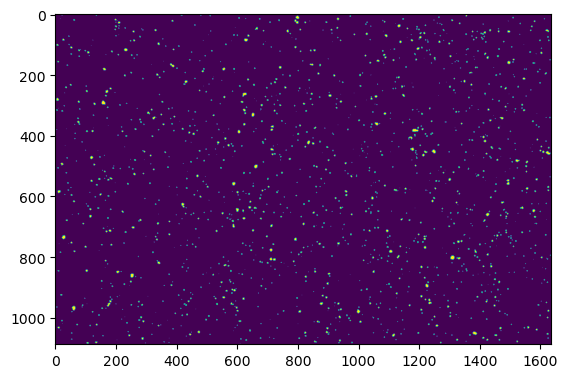

In [34]:
# いくつかの対象が画面の端(border)と接しているのでこれらを除く
mask_bin = clear_border(mask_bin)
plt.imshow(mask_bin)

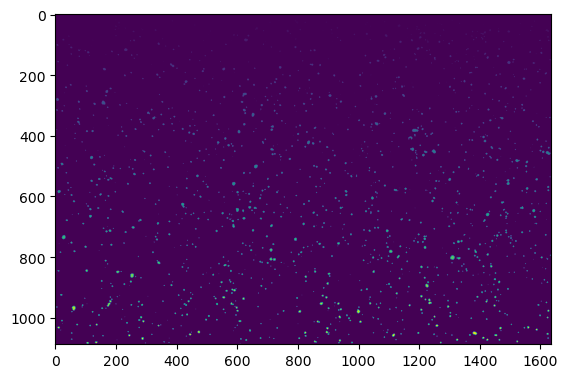

In [35]:
# 重なっている対象がほとんど無いので、そのままラベリング
# もし重なっている対象が多い場合はwatershed等で分割を試みる
ret, markers, stats, centroids = cv2.connectedComponentsWithStats(mask_bin)
plt.imshow(markers)

In [38]:
# 蛍光強度の測定、intensity_imgのオリジナルのimgを指定
# 今回は実際の画像"Image_intensity"は計測項目に入れない
prop_dic = regionprops_table(markers, intensity_image = img, properties=["label", "area", "intensity_mean", "intensity_max", "axis_major_length", "axis_minor_length","perimeter", "solidity", "feret_diameter_max"])
data = pd.DataFrame(prop_dic)

In [39]:
data.head()

,label,area,intensity_mean,intensity_max,axis_major_length,axis_minor_length,perimeter,solidity,feret_diameter_max
0,1,9,6988.222222,7801.0,3.885753,2.795443,8.242641,1.0,4.123106
1,2,18,8584.111111,11729.0,5.258738,4.268749,12.828427,1.0,5.385165
2,3,14,7411.500000,9384.0,4.742873,3.686026,11.071068,1.0,5.099020
3,4,7,6674.285714,7376.0,3.703280,2.138090,6.828427,1.0,3.605551
4,5,22,7805.000000,9491.0,6.559967,4.162989,14.828427,1.0,6.708204


In [42]:
# areaはpixel数で表されているので、area_pixにrename
# さらに長さの単位であるµm^2に変換したAreaを追加
data["Area"] = data.area * (vsize.x)**2
data = data.rename({"area": "area_pix"}, axis = 1)

In [43]:
data.head()

,label,area_pix,intensity_mean,intensity_max,axis_major_length,axis_minor_length,perimeter,solidity,feret_diameter_max,Area
0,1,9,6988.222222,7801.0,3.885753,2.795443,8.242641,1.0,4.123106,0.069727
1,2,18,8584.111111,11729.0,5.258738,4.268749,12.828427,1.0,5.385165,0.139454
2,3,14,7411.500000,9384.0,4.742873,3.686026,11.071068,1.0,5.099020,0.108464
3,4,7,6674.285714,7376.0,3.703280,2.138090,6.828427,1.0,3.605551,0.054232
4,5,22,7805.000000,9491.0,6.559967,4.162989,14.828427,1.0,6.708204,0.170444


In [44]:
# 0.04 =<Area =< 500のデータを抽出する
data= data[(data.Area >= 0.04) & (data.Area <= 500)]

In [45]:
data.head()

,label,area_pix,intensity_mean,intensity_max,axis_major_length,axis_minor_length,perimeter,solidity,feret_diameter_max,Area
0,1,9,6988.222222,7801.0,3.885753,2.795443,8.242641,1.0,4.123106,0.069727
1,2,18,8584.111111,11729.0,5.258738,4.268749,12.828427,1.0,5.385165,0.139454
2,3,14,7411.500000,9384.0,4.742873,3.686026,11.071068,1.0,5.099020,0.108464
3,4,7,6674.285714,7376.0,3.703280,2.138090,6.828427,1.0,3.605551,0.054232
4,5,22,7805.000000,9491.0,6.559967,4.162989,14.828427,1.0,6.708204,0.170444


In [46]:
data["aspect_ratio"] = data.axis_major_length/data.axis_minor_length
data["Roundness"] = 1/data.aspect_ratio
data["IntDen"] = data.Area * data.intensity_mean # Integrated Density, µm^2ベース
data["RawIntDen"] = data.area_pix * data.intensity_mean # Integrated Density, pixel ベース

# データを解析した日付とファイル名を表す変数を追加
date = "2023-08-14"
filename = os.path.basename(path)
data["Date"] = date
data["File"] = filename

In [47]:
# 列の並べ替え
data = data.iloc[:, [0, 14, 15, 9,1,2,12,13,3,4,5,6,7,8,10,11]]
# インデックスを振り直す, 古いindexが変数"index"となるので削除
data = data.reset_index(drop=True)
data.head(20)

,label,Date,File,Area,area_pix,intensity_mean,IntDen,RawIntDen,intensity_max,axis_major_length,axis_minor_length,perimeter,solidity,feret_diameter_max,aspect_ratio,Roundness
0,1,2023-08-14,Ade4-mNG_amp_0uM_002.nd2,0.069727,9,6988.222222,487.267675,62894.0,7801.0,3.885753,2.795443,8.242641,1.000000,4.123106,1.390031,0.719408
1,2,2023-08-14,Ade4-mNG_amp_0uM_002.nd2,0.139454,18,8584.111111,1197.088396,154514.0,11729.0,5.258738,4.268749,12.828427,1.000000,5.385165,1.231915,0.811744
2,3,2023-08-14,Ade4-mNG_amp_0uM_002.nd2,0.108464,14,7411.500000,803.882425,103761.0,9384.0,4.742873,3.686026,11.071068,1.000000,5.099020,1.286717,0.777171
3,4,2023-08-14,Ade4-mNG_amp_0uM_002.nd2,0.054232,7,6674.285714,361.960533,46720.0,7376.0,3.703280,2.138090,6.828427,1.000000,3.605551,1.732051,0.577350
4,5,2023-08-14,Ade4-mNG_amp_0uM_002.nd2,0.170444,22,7805.000000,1330.313425,171710.0,9491.0,6.559967,4.162989,14.828427,1.000000,6.708204,1.575783,0.634605
5,6,2023-08-14,Ade4-mNG_amp_0uM_002.nd2,0.069727,9,6777.111111,472.547534,60994.0,7558.0,3.885753,2.795443,8.242641,1.000000,4.123106,1.390031,0.719408
6,7,2023-08-14,Ade4-mNG_amp_0uM_002.nd2,0.100717,13,8005.923077,806.330617,104077.0,10299.0,4.318667,3.679465,10.242641,1.000000,4.472136,1.173722,0.851991
7,8,2023-08-14,Ade4-mNG_amp_0uM_002.nd2,0.689522,89,10179.865169,7019.245270,906008.0,16155.0,11.539238,9.850230,32.142136,0.978022,12.083046,1.171469,0.853629
8,9,2023-08-14,Ade4-mNG_amp_0uM_002.nd2,0.100717,13,7360.230769,741.298581,95683.0,9190.0,4.417039,3.817409,11.071068,0.928571,5.099020,1.157078,0.864246
9,10,2023-08-14,Ade4-mNG_amp_0uM_002.nd2,0.123959,16,7652.312500,948.573669,122437.0,9524.0,4.999310,3.993044,12.242641,0.941176,5.385165,1.252005,0.798719


In [48]:
# ナンバリング画像を作る関数
# dataに残っている、0.04 < Area < 500のラベルについてのみ番号を振る
labels = data.label# dataからlabelを抽出
def numbering2(img_segm, stats, labels):
    numbered_img = img_segm.copy()
    for label in labels:
        x, y, width, height, area = stats[label] 
        cv2.putText(numbered_img, f"{label}", (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.75, (255, 255, 255), 1, cv2.LINE_AA)
    return numbered_img

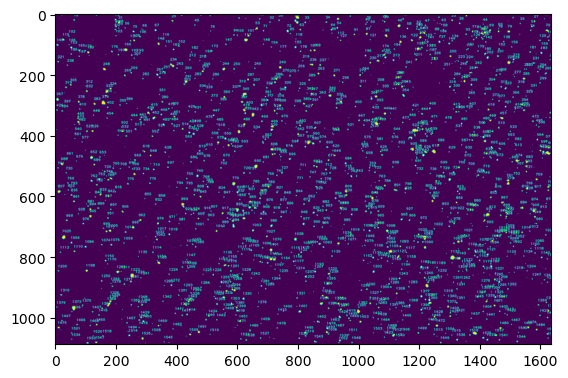

In [49]:
img_numbered = numbering2(mask_bin, stats, labels)
plt.imshow(img_numbered)

### 関数化  
データフレーム作成までを関数化,inputはimg, date, filename

In [2]:
def analyze_vitro_particles(nd2_arr, date, filename):

    img = nd2_arr[0,:,:]
    mask = img.copy()
    phase = nd2_arr[1,:,:]
    mask = img.copy()

    radius = 20
    background = restoration.rolling_ball(mask, radius = radius, kernel=None,
                                         nansafe=False, num_threads=None)
    filtered = mask - background
    thr = filtered.mean() + 3*filtered.std() # 2値化の閾値を設定
    mask_bin = np.where(filtered > thr, 255, 0).astype("uint8")
    mask_bin = clear_border(mask_bin)
    
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(mask_bin)
    prop_list = ["label", "area", "intensity_mean", "intensity_max", "axis_major_length", "axis_minor_length","perimeter", "solidity", "feret_diameter_max"]
    prop_dic = regionprops_table(markers, intensity_image = img, properties= prop_list)
    data = pd.DataFrame(prop_dic)
    
    data["Area"] = data.area * (vsize.x)**2
    data = data.rename({"area": "area_pix"}, axis = 1)
    
    data= data[(data.Area >= 0.04) & (data.Area <= 500)]
    data["aspect_ratio"] = data.axis_major_length/data.axis_minor_length
    data["Roundness"] = 1/data.aspect_ratio
    data["IntDen"] = data.Area * data.intensity_mean # Integrated Density, µm^2ベース
    data["RawIntDen"] = data.area_pix * data.intensity_mean # Integrated Density, pixel ベース
    # basename = os.path.basename(path)
    data["Date"] = date
    data["File"] = filename
    data["Threshold"] = thr
    data = data.iloc[:, [0,14,15,9,1,2,12,13,3,4,5,6,7,8,10,11,16]]
    data = data.reset_index(drop=True)
    
    return img, phase, mask_bin, markers, stats, data

In [3]:
def numbering2(img_segm, stats, labels):
    numbered_img = img_segm.copy()
    for label in labels:
        x, y, width, height, area = stats[label] 
        cv2.putText(numbered_img, f"{label}", (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.75, (255, 255, 255), 1, cv2.LINE_AA)
    return numbered_img

In [62]:
# 確認
# Main code
date = "2023-08-01"
path = "/Users/masak_takaine/230329_Ade4-mNG_ivc/nd_test/Ade4-mNG_500u_mock_034.nd2"
basename = os.path.basename(path)
filename = basename.split(".")[0]

nd2_arr =nd2.imread(path) # 画像をndarrayとして読み込み
with nd2.ND2File(path) as f: # with構文でファイルを開くと様々なメタデータが抽出できる
    vsize = f.voxel_size() # 
    
img, phase, mask_bin, markers, stats, data = analyze_vitro_particles(nd2_arr, date, filename)
labels = data.label# dataからlabelを抽出
numbered_img = numbering2(mask_bin, stats, labels)

In [63]:
data.head()

,label,Date,File,Area,area_pix,intensity_mean,IntDen,RawIntDen,intensity_max,axis_major_length,axis_minor_length,perimeter,solidity,feret_diameter_max,aspect_ratio,Roundness,Threshold
0,1,2023-08-01,Ade4-mNG_500u_mock_034,0.069727,9,5971.222222,416.355330,53741.0,6966.0,3.885753,2.795443,8.242641,1.000000,4.123106,1.390031,0.719408,3494.368772
1,2,2023-08-01,Ade4-mNG_500u_mock_034,0.123959,16,7632.187500,946.078993,122115.0,10668.0,4.928175,4.230909,12.656854,0.842105,5.385165,1.164803,0.858514,3494.368772
2,4,2023-08-01,Ade4-mNG_500u_mock_034,0.139454,18,9061.944444,1263.724153,163115.0,13677.0,5.416026,4.216370,13.656854,0.900000,6.082763,1.284523,0.778499,3494.368772
3,5,2023-08-01,Ade4-mNG_500u_mock_034,0.356382,46,10337.326087,3684.040818,475517.0,16211.0,8.158700,7.184766,22.485281,0.958333,8.544004,1.135555,0.880626,3494.368772
4,6,2023-08-01,Ade4-mNG_500u_mock_034,0.131707,17,8571.294118,1128.895404,145712.0,12238.0,4.957955,4.338609,12.828427,0.944444,5.385165,1.142752,0.875080,3494.368772


#### バッチ処理化
上記の画像処理を、フォルダ内の複数の画像ファイルに対して適用できるようマクロを修正。  
緑蛍光画像、位相差画像、およびナンバリングした2値画像をそれぞれ別のフォルダに保存。  
各ファイルにおける粒子の測定結果を全てまとめた「particle_data.csv」と、各ファイルごとの統計量をまとめた「particle_stats.csv」を作成、保存する

In [5]:
# %%timeit -n 3 -r 3
# バッチ処理化
# source folder内のファイルリストを取得して順番に処理、拡張子の無いファイル名、測定結果のデータフレーム、ナンバリングした2値化画像、resolutionのタプル、メタデータをそれぞれリストに格納
# 処理が終わったら、folderDの下のcsvとsegmented_imagesにそれぞれcsvファイルと2値化した画像を保存
# folderS = "/Users/masak_takaine/230329_Ade4-mNG_ivc/nd_test"
folderS = "/Users/masak_takaine/230926_Ade4-mNG_ivc/nd"
# folderS = "/Users/masak_takaine/230331_Ade4-mNG_ivc/nd"
# folderD = "/Users/masak_takaine/Desktop/20230814"
folderD = "/Users/masak_takaine/230926_Ade4-mNG_ivc/230926_ivc_python_output"
# date = "2023-08-14_test"
date = "230926_ivc_python"
file_list = glob.glob(folderS + "/*") #フォルダ内の全てのfile/folderのリストを取得して、ソートしておく
file_list.sort(reverse=True) 

# 各ファイルの解析結果を格納するリスト
fname_list = []
img_list = []
phase_list = []
mask_list = []
df_list = []
vsize_list =[]


img_folder = os.path.join(folderD, "green")
if not os.path.exists(img_folder):  #dirが存在しなければ作成する
    os.mkdir(img_folder)  

phase_folder = os.path.join(folderD, "BF")
if not os.path.exists(phase_folder):  #dirが存在しなければ作成する
    os.mkdir(phase_folder) 
    
mask_folder = os.path.join(folderD, "mask")
if not os.path.exists(mask_folder):  #dirが存在しなければ作成する
    os.mkdir(mask_folder) 

for path in file_list:
    if ".nd2" in path:
        basename = os.path.basename(path)
        filename = basename.split(".")[0]
        nd2_arr =nd2.imread(path) # 画像をndarrayとして読み込み
        with nd2.ND2File(path) as f: # with構文でファイルを開くと様々なメタデータが抽出できる
            vsize = f.voxel_size() # 
        img, phase, mask_bin, markers, stats, data = analyze_vitro_particles(nd2_arr, date, filename)
        labels = data.label# dataからlabelを抽出
        numbered_img = numbering2(mask_bin, stats, labels)
        
        fname_list.append(filename)
        img_list.append(img)
        phase_list.append(phase)
        mask_list.append(numbered_img)
        df_list.append(data)
        vsize_list.append(vsize)

# 個々の粒子のデータをまとめたparticle_data.csvの作成と保存
df_concat = pd.concat(df_list)
df_concat = df_concat.reset_index(drop=True)
fdata_csv_savepath = os.path.join(folderD, date + "_particle_data.csv")
df_concat.to_csv(fdata_csv_savepath)


# df_concatからparticle_statを作成
# Date列を落としてからfilenameでグループ化
grouped = df_concat.drop("Date", axis=1).groupby("File")
# meanとsizeでそれぞれ平均と個数を計算
grouped_mean = grouped.mean().reset_index() # reset_index()することで、groupbyオブジェクトではなくデータフレームになる
grouped_size = grouped.size().reset_index()
grouped_mean["particle_num"] = grouped_size[0]
grouped_mean["Date"] = date
# 各ファイル（各視野）におけるSum of Integrated densityを計算
grouped_mean["Sum_intdens"] = grouped_mean.IntDen * grouped_mean.particle_num
grouped_mean["Raw_sum_intdens"] = grouped_mean.RawIntDen * grouped_mean.particle_num
# 不要な変数を消去
grouped_mean = grouped_mean.drop(["label", "axis_major_length", "axis_minor_length", "perimeter", "feret_diameter_max"], axis=1)
grouped_mean = grouped_mean.rename(columns={"Area": "Mean_Area", "area_pix":"Mean_Area_pix", "intensity_mean":"Mean_meanint","IntDen":"Mean_IntDen", "RawIntDen":"Mean_RawIntDen", "intensity_max":"Mean_Int_max", "solidity":"Mean_Solidity", "aspect_ratio":"Mean_AR", "Roundness":"Mean_Roundness"})
# 列を並べ替える
grouped_mean = grouped_mean.iloc[:, [12, 0, 11, 1,2,3,4,5,6,13,14,7,8,9,10]]
stat_csv_savepath = os.path.join(folderD, date + "_particle_stats.csv")
grouped_mean.to_csv(stat_csv_savepath)

# 画像の保存
# 観察中に解像度が変更されることは無いので、最初のvsizeだけ使用
vsize0 = vsize_list[0]
reso = (1/vsize0.x, 1/vsize0.y)
for filename, img, phase, mask in zip(fname_list, img_list, phase_list, mask_list):
    tiff.imwrite(os.path.join(img_folder, filename + ".tif"), img, imagej=True, resolution= reso,
             metadata={'unit': 'um','axes': 'YX'})
    tiff.imwrite(os.path.join(phase_folder, filename + ".tif"), phase, imagej=True, resolution= reso,
             metadata={'unit': 'um','axes': 'YX'})
    tiff.imwrite(os.path.join(mask_folder, filename + ".tif"), mask, imagej=True, resolution= reso,
             metadata={'unit': 'um','axes': 'YX'})
    

In [70]:
# df_concatからparticle_statを作成
# Date列を落としてからfilenameでグループ化
grouped = df_concat.drop("Date", axis=1).groupby("File")

In [71]:
# meanとsizeでそれぞれ平均と個数を計算
# reset_index()することで、groupbyオブジェクトではなくデータフレームになる
grouped_mean = grouped.mean().reset_index() 
grouped_size = grouped.size().reset_index()

In [73]:
grouped_mean["particle_num"] = grouped_size[0]
grouped_mean["Date"] = date

In [74]:
# 各ファイル（各視野）におけるSum of Integrated densityを計算
grouped_mean["Sum_intdens"] = grouped_mean.IntDen * grouped_mean.particle_num
grouped_mean["Raw_sum_intdens"] = grouped_mean.RawIntDen * grouped_mean.particle_num

In [75]:
# 不要な変数を消去
grouped_mean = grouped_mean.drop(["label", "axis_major_length", "axis_minor_length", "perimeter", "feret_diameter_max"], axis=1)

In [76]:
grouped_mean = grouped_mean.rename(columns={"Area": "Mean_Area", "area_pix":"Mean_Area_pix", "intensity_mean":"Mean_meanint","IntDen":"Mean_IntDen", "RawIntDen":"Mean_RawIntDen", "intensity_max":"Mean_Int_max", "solidity":"Mean_Solidity", "aspect_ratio":"Mean_AR", "Roundness":"Mean_Roundness"})

In [77]:
# 列を並べ替える
grouped_mean = grouped_mean.iloc[:, [12, 0, 11, 1,2,3,4,5,6,13,14,7,8,9,10]]
grouped_mean

,Date,File,particle_num,Mean_Area,Mean_Area_pix,Mean_meanint,Mean_IntDen,Mean_RawIntDen,Mean_Int_max,Sum_intdens,Raw_sum_intdens,Mean_Solidity,Mean_AR,Mean_Roundness,Threshold
0,2023-08-14,Ade4-mNG_nonfreezed_001,1272,0.149912,19.349843,6456.233566,1085.413520,140099.582547,9039.018868,1.380646e+06,178206669.0,0.964157,1.270456,0.816756,2585.365589
1,2023-08-14,Ade4-mNG_nonfreezed_002,1227,0.158036,20.398533,5915.061896,1041.151363,134386.451508,8303.401793,1.277493e+06,164892176.0,0.962615,1.273570,0.814756,2334.920410
2,2023-08-14,Ade4-mNG_nonfreezed_003,804,0.219328,28.309701,5678.102716,1379.845140,178103.298507,8007.839552,1.109395e+06,143195052.0,0.951031,1.356448,0.773229,2091.672274


#### さらに、読み込むファイルの入ったフォルダ（source folder）と保存先のフォルダ（destination folder）をGUIで指定できるようにする

In [ ]:
layout = [
    [sg.Text("Date of experiments:"), sg.InputText(key="date",default_text = "test")],
   [sg.Text("Source folder:"), sg.InputText(key="folderS")],[sg.FolderBrowse(target="folderS", initial_folder= os.getcwd())],
    [sg.Text("Destination folder:"), sg.InputText(key="folderD")],[sg.FolderBrowse(target="folderD", initial_folder= os.getcwd())],
          [sg.Submit(), sg.Cancel()],
]

window = sg.Window("Choose folders", layout)
while True:
    event, values = window.read()
    if event in (sg.WIN_CLOSED, 'Cancel'):
        break
    # elif event == 'Submit':
    else:
        date = values["date"]
        folderS = values["folderS"]
        folderD = values["folderD"]
        file_list = glob.glob(folderS + "/*") #フォルダ内の全てのfile/folderのリストを取得して、ソートしておく
        file_list.sort(reverse=True) 

        # 各ファイルの解析結果を格納するリスト
        fname_list = []
        img_list = []
        phase_list = []
        mask_list = []
        df_list = []
        vsize_list =[]


        img_folder = os.path.join(folderD, "green")
        if not os.path.exists(img_folder):  #dirが存在しなければ作成する
            os.mkdir(img_folder)  

        phase_folder = os.path.join(folderD, "BF")
        if not os.path.exists(phase_folder):  #dirが存在しなければ作成する
            os.mkdir(phase_folder) 

        mask_folder = os.path.join(folderD, "mask")
        if not os.path.exists(mask_folder):  #dirが存在しなければ作成する
            os.mkdir(mask_folder) 

        for path in file_list:
            if ".nd2" in path:
                basename = os.path.basename(path)
                filename = basename.split(".")[0]
                nd2_arr =nd2.imread(path) # 画像をndarrayとして読み込み
                with nd2.ND2File(path) as f: # with構文でファイルを開くと様々なメタデータが抽出できる
                    vsize = f.voxel_size() # 
                img, phase, mask_bin, markers, stats, data = analyze_vitro_particles(nd2_arr, date, filename)
                labels = data.label# dataからlabelを抽出
                numbered_img = numbering2(mask_bin, stats, labels)

                fname_list.append(filename)
                img_list.append(img)
                phase_list.append(phase)
                mask_list.append(numbered_img)
                df_list.append(data)
                vsize_list.append(vsize)

        # 個々の粒子のデータをまとめたparticle_data.csvの作成と保存
        df_concat = pd.concat(df_list)
        df_concat = df_concat.reset_index(drop=True)
        fdata_csv_savepath = os.path.join(folderD, date + "_particle_data.csv")
        df_concat.to_csv(fdata_csv_savepath)


        # df_concatからparticle_statを作成
        # Date列を落としてからfilenameでグループ化
        grouped = df_concat.drop("Date", axis=1).groupby("File")
        # meanとsizeでそれぞれ平均と個数を計算
        grouped_mean = grouped.mean().reset_index() # reset_index()することで、groupbyオブジェクトではなくデータフレームになる
        grouped_size = grouped.size().reset_index()
        grouped_mean["particle_num"] = grouped_size[0]
        grouped_mean["Date"] = date
        # 各ファイル（各視野）におけるSum of Integrated densityを計算
        grouped_mean["Sum_intdens"] = grouped_mean.IntDen * grouped_mean.particle_num
        grouped_mean["Raw_sum_intdens"] = grouped_mean.RawIntDen * grouped_mean.particle_num
        # 不要な変数を消去
        grouped_mean = grouped_mean.drop(["label", "axis_major_length", "axis_minor_length", "perimeter", "feret_diameter_max"], axis=1)
        grouped_mean = grouped_mean.rename(columns={"Area": "Mean_Area", "area_pix":"Mean_Area_pix", "intensity_mean":"Mean_meanint","IntDen":"Mean_IntDen", "RawIntDen":"Mean_RawIntDen", "intensity_max":"Mean_Int_max", "solidity":"Mean_Solidity", "aspect_ratio":"Mean_AR", "Roundness":"Mean_Roundness"})
        # 列を並べ替える
        grouped_mean = grouped_mean.iloc[:, [12, 0, 11, 1,2,3,4,5,6,13,14,7,8,9,10]]
        stat_csv_savepath = os.path.join(folderD, date + "_particle_stats.csv")
        grouped_mean.to_csv(stat_csv_savepath)

        # 画像の保存
        # 観察中に解像度が変更されることは無いので、最初のvsizeだけ使用
        vsize0 = vsize_list[0]
        reso = (1/vsize0.x, 1/vsize0.y)
        for filename, img, phase, mask in zip(fname_list, img_list, phase_list, mask_list):
            tiff.imwrite(os.path.join(img_folder, filename + ".tif"), img, imagej=True, resolution= reso,
                     metadata={'unit': 'um','axes': 'YX'})
            tiff.imwrite(os.path.join(phase_folder, filename + ".tif"), phase, imagej=True, resolution= reso,
                     metadata={'unit': 'um','axes': 'YX'})
            tiff.imwrite(os.path.join(mask_folder, filename + ".tif"), mask, imagej=True, resolution= reso,
                     metadata={'unit': 'um','axes': 'YX'})
    
        print("Done.")
        break
        
window.close()

### 考察  
20230331のデータを使用して、FIJI Jythonマクロと上記のPythonでの処理を比較。  
合計54個のファイルを処理するのにJythonでは47秒、Pythonでは1分かかった。  
Jythonでは個別のcsvファイルを保存しているのに対し、Pythonではそれらを連結しているのでその分時間がかかるのか。  
それぞれのparticle_statファイルにおけるparticel_num, Mean_Area, Mean_MeanInt, MeanIntDen, Sum_IntDenを比較したところ、数値にほとんど差は無かった  
例: Python/Jython ratio = 99.7±0.7% (particle_num), 99.85±0.37% (Sum_IntDen)  
よってほぼ完全にJythonマクロの機能をPythonで再現できたと言ってよいだろう。